In [ ]:
%%writefile Group3WebCrawlingv5.py

"""
* 과목: 빅데이터컴퓨팅
* 조: 3조
* 조원: 김다빈 20171218 | 김수빈 20180718 | 오주환 20150622
* 요약: 네이버 지도 웹사이트 크롤링 데이터기반 유저 취향 맞춤 공간x지역 리뷰분석

* 코드 실행시 필요한 준비사항

0. path : 구동에 필요한 하기 파일들의 경로는 './' 입니다. 현재 .py 파일과 동일한 디렉토리에 있으면 구동가능합니다.

1. chromedrive : selenium 실행을 위해서 필요 (현재 window 크롬 v99버전 호환 드라이버를 첨부하였습니다. \ 
                                                v98 v100 버전은 따로 다운로드를 받아야 합니다.)
                                            주소: https://chromedriver.chromium.org/downloads
                                            
2. NanumFont : plt.bar()  한글 출력을 위해서 나눔폰트를 설치해야합니다. 
              첨부파일에 동봉하였습니다. 
              주소: https://hangeul.naver.com/font


3. .xlsx파일 : 본 코드는 크롤링 코드가 구현되어 있고 메인문에서 크롤링이 작동하게끔 구현되어있습니다만,
            데이터를 다운받는데 시간이 오래걸리기 때문에 미리 .xlsx 파일을 첨부하였습니다.
            크롤링을 off 하기위해서는 __main__ 부근에  navermap_crawling(keyword) <= 코드를 주석처리 하시기 바랍니다.
            off하면 크롤링 기능을 제외하고 작동됨 (단, .xlsx 파일이 .py파일 path에 있어야합니다.)
"""




# 0. libarary import

import os
from bs4 import *
from urllib.request import *
from selenium import webdriver
import time
import pandas as pd
import numpy as np
import re
import nltk
from konlpy.tag import Kkma
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

file_path_0 = './'

# 1. Get keyword (region, area)
def get_input() :
    print("1. 신촌, 2. 합정, 3. 홍대")
    while(1) :
        region_num = int(input("관심있는 탐색 지역의 번호를 입력해주세요 : "))
        if (region_num == 1) : 
            region = "신촌"
            break
        elif (region_num == 2) : 
            region = "합정"
            break
        elif (region_num == 3) : 
            region = "홍대"
            break
        else : continue
    print()
    print("1. 식당, 2. 술집, 3. 카페")
    while(1) :
        area_num = int(input("관심있는 탐색 공간의 번호를 입력해주세요 : "))
        if (area_num == 1) : 
            area = "식당"
            break
        elif (area_num == 2) : 
            area = "술집"
            break
        elif (area_num == 3) : 
            area = "카페"
            break
        else : continue
    return region, area 


# 2.Crawling (Naver map)

def navermap_crawling (search_for) :
    path="./chromedriver"
    browser = webdriver.Chrome(path)
    keyword = search_for

    #--------------------------------------------

    #2.1. 활용할 함수 정의
    #xpath(a)의 버튼을 누르는 함수
    def btn_xpath(a) :
        button = browser.find_element_by_xpath(a)
        button.click()
        time.sleep(1)

    #--------------------------------------------

    #2.2. url_set - 장소명(keyword) 검색 

    url = 'https://m.map.naver.com/search2/search.naver?query=' + keyword + '&sm=hty&style=v5'
    browser.get(url)
    time.sleep(3)

    #--------------------------------------------

    #2.3. Crawling - 검색 리스트의 각 장소이름 및 장소id

    html = browser.page_source
    soup = BeautifulSoup(html,'html.parser')

    #2.3-1. 장소이름
    name = soup.find_all("div",{"class":"item_tit _title"})
    shop_name2 = []
    for n in name:
        shop_name2.append(n.text)
    shop_name = shop_name2[0:10]

    #2.3-2. 장소id
    info = soup.find("ul",{"class":"search_list _items"}).find_all("li",{"class":"_item _lazyImgContainer"})
    shop_id2 = []
    for i in info:
        shop_id2.append(i.get("data-sid"))
    shop_id = shop_id2[0:10]

    print("다음 장소들의 리뷰를 분석합니다.\n", shop_name)
    print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ")

    #--------------------------------------------
    
    #2.4. Crawling - '이런 점이 좋았어요'

    review_category = []

    #2.4-1. url_set - 점포id 이용하여 각 점포의 방문자 리뷰 페이지 접속
    for id in range(len(shop_id)) :
        url = "https://m.place.naver.com/restaurant/" + shop_id[id] + "/review/visitor?type=list"
        browser.get(url)
        time.sleep(3)

         #2.4-2. 더보기 버튼 클릭
        try :
            for i in range(2):
                btn_xpath('/html/body/div[3]/div/div/div[2]/div[5]/div[4]/div[1]/div/div/div[2]/a')
                time.sleep(1)
                    #4-3. Crawling - '이런 점이 좋았어요' 항목 이름, 개수 크롤링
            html = browser.page_source
            soup = BeautifulSoup(html,'html.parser')
            category = soup.find_all("li",{"class":"_3FaRE"})
            
            #2.4-3. 투표자수 값 추출
            vote_num = soup.find("div",{"class":"_3zxNp"})
            vote_num = vote_num.find("span",{"class":"Nqp-s"}).text
            vote_num = re.search("(\d+)명",vote_num).groups()[0]
            review_category.append([shop_name[id], "총투표자수", vote_num])
           
        except :
            pass
        time.sleep(3)

        try :
            for rv in category :
                cate = rv.find("span",{"class":"_1lntw"}).text #항목 이름
                n = rv.find("span",{"class":"Nqp-s"}).text #항목 개수
                n = re.findall("\d+", n)
                n = int(n[0])
                review_category.append([shop_name[id], cate, n])
        except :
            pass
        time.sleep(1)
        print(len(shop_name), "개 중",id+1,"번째 장소를 분석 중입니다.", ) #진행상황 확인

    #2.4-4. DataFrame - 각 행과 열에 맞게 데이터 구조화
    review_visitor_list_np = np.array(review_category).reshape(-1, 3)
    review_visitor = pd.DataFrame(review_visitor_list_np, columns = ["shop_name","category","n"])
    review_visitor.to_excel("navermap_" + keyword + "_ReviewCategory.xlsx", index = False)

    print(keyword, "의 카테고리 분석이 완료되었습니다.")
    print("ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ")

    time.sleep(3)

    #2.5. Crawling - 방문자 리뷰

    review_visitor_list = []

    #2.5-1. url_set - 점포id 이용하여 각 점포의 방문자 리뷰 페이지 접속
    for id in range(len(shop_id)):
        url = "https://m.place.naver.com/restaurant/" + shop_id[id] + "/review/visitor?type=list"
        browser.get(url)
        time.sleep(3)

        #2.5-2. 스크롤다운, 더보기 버튼 클릭
        while True:
            try:
                browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(1)
                btn_xpath('/html/body/div[3]/div/div/div[2]/div[5]/div[4]/div[3]/div[2]/a')
                time.sleep(1)
            except:
                break
        time.sleep(5)

        #2.5-3. Crawling - 방문자 리뷰내용 크롤링
        html = browser.page_source
        soup = BeautifulSoup(html,'html.parser')
        review = soup.find_all("li",{"class":"_3FaRE"})
        
        for rv in review:
            content = rv.find("span",{"class":"WoYOw"}) #리뷰 내용

            #2.5-4. 정제 - 방문자 리뷰의 내용이 없고 사진만 있는 경우 결측치 "No Contents"로 채우기
            if content != None:
                content = content.text
            else:
                content = "No Contents"
            review_visitor_list.append([shop_name[id], content])
            
        time.sleep(1)
        print(len(shop_name), "개 중",id+1, "번째 장소를 분석 중입니다.", ) #진행상황 확인

    #2.5-5. DataFrame - 각 행과 열에 맞게 데이터 구조화
    review_visitor_list_np = np.array(review_visitor_list).reshape(-1, 2)
    review_visitor = pd.DataFrame(review_visitor_list_np, columns = ["shop_name","content"])
    review_visitor.to_excel("navermap_" + keyword + "_VisitorReview.xlsx", index = False)

    print(keyword, "의 리뷰 분석이 완료되었습니다.")
    
# ---------------------------------------------------

# 3. Data Processing & Analysis


def dataProcessing(key,path=None):
    
    dic_all = {}
    if path == None:
        path = "./navermap_@@@@_ReviewCategory.xlsx"
    
    file_path = path
    #3.2.1 파일경로 설정
    file_path = re.sub(r'@@@@',key,file_path)

    #3.2.2 데이터 로드
    df_reviewTag = pd.read_excel(file_path)
    df_reviewTag.head(2)

    #3.3.1 가게명 정리
    shopName = df_reviewTag.iloc[:,0].unique()

    #3.3.2 카테고리 정리
    tagCategory = df_reviewTag.iloc[:,1].unique()

    #3.4. 통합 df 생성
    df_reviewTagAll = pd.DataFrame(columns=tagCategory).sort_index(1)

    #3.4.1 각 가게별로 태그 값 통합
    cnt =0
    for name in shopName:
        tmp = df_reviewTag[df_reviewTag['shop_name']==name]
        tagCategory = tmp.T.iloc[1,:]
        num = tmp.T.iloc[-1,:]
        tmp2 = pd.DataFrame(columns=tagCategory)
        tmp2.loc[cnt] = list(num)
        tmp2.sort_index(1)
        df_reviewTagAll = pd.concat([df_reviewTagAll,tmp2])
        cnt +=1

    #3.4.2.1 결측값 처리
    df_reviewTagAll = df_reviewTagAll.fillna(0)
    df_reviewTagAll.iloc[:,1:].astype(int)
    df_reviewTagAll=df_reviewTagAll.astype(int)
    df_reviewTagAll = df_reviewTagAll.sort_index(1)

#         #3.4.2.2 총투표자수가 0명일때 처리방법
#         idxList = list(df_reviewTagAll[df_reviewTagAll.iloc[:,-1]==0].index)

#         if len(idxList) >=1:
#             for idx in idxList:
#                 df_reviewTagAll.iloc[idx,-1] = df_reviewTagAll.iloc[idx,1:-1].max() * 1.5

    #3.4.3 가게이름 행추가
    df_reviewTagAll.insert(0,'shop_name',shopName)

    #3.5.1  고빈도 태그 10 추출
    df_categoryScores = df_reviewTagAll.transpose().drop('shop_name').sum(axis=1)
    df_categoryScores = df_categoryScores.sort_values(ascending=False)

    #3.5.2 dropRatio=0.6 if len(df_reviewTagAll.columns) >= 25 else 0.8
    df_categoryScores = df_categoryScores[:10:-1]
    df_reviewTagTop10=df_reviewTagAll.drop(columns=list(df_categoryScores.index))

    #3.6. 투표자수로 나눠준 비율추출
    df_reviewTagTop10Ratio=df_reviewTagTop10.copy()
    for row in df_reviewTagTop10.index:
        tmp = (df_reviewTagTop10.iloc[row,1:-1] / df_reviewTagTop10.iloc[row,-1])*100
        tmp = tmp.map(lambda x: round(x,1))
        tmp.loc['Total vote'] = df_reviewTagTop10.iloc[row,-1]
        df_reviewTagTop10Ratio.iloc[row,1:] = tmp
    df_reviewTagTop10Ratio

    #3.7. 카테고리별 mean/median/std 추출
    df_Describe = df_reviewTagTop10Ratio.describe().iloc[[1,2,3,5,7],:].apply(lambda x: round(x,1))
    df_Describe

    #3.8. 카테고리별 상위 5개 추출
    dic_Top5 = {}
    for i in range(1,len(df_reviewTagTop10Ratio.columns)-1):
        tmp = df_reviewTagTop10Ratio.iloc[:,[0,i,-1]]
        tmp = tmp.sort_values(by=df_reviewTagTop10Ratio.columns[i],ascending=False)
        tmp = tmp.iloc[:5,:]
        name = tmp.columns[1]
        dic_Top5[name] =tmp

    #3.9 각종 df 저장
    dic_all = {'all':df_reviewTagAll,'top10':df_reviewTagTop10,'top10Ratio':df_reviewTagTop10Ratio, \
                   'describe': df_Describe,'categoryTop5':dic_Top5}   
    return dic_all

#-----------------------------------------

#4. Get user preference

#4.1 카테고리 선택 입력 함수
def select_category(region, area, df_reviewTagAll, num) :
    print(region + " " + area + "의 네이버맵 검색 상위 10개 가게와 취향을 매치합니다.")
    print(region + " " + area + "에 대한 취향을 번호로 선택해 입력해주세요.")
    
    df_categoryScores = df_reviewTagAll.transpose().drop('shop_name').sum(axis=1)
    df_categoryScores = df_categoryScores.sort_values(ascending=False)
    df_categoryScores = df_categoryScores[:num+1]
    df_categoryScores = list(df_categoryScores.index)
    
    
    if (area == '술집') :
        category_dict = {
            '"음식이 맛있어요"' : '맛있는 음식',
            '"친절해요"' : '친절',
            '"술이 다양해요"' : '다양한 주류',
            '"특별한 메뉴가 있어요"' : '특별한 메뉴',
            '"인테리어가 멋져요"' : '인테리어',
            '"가성비가 좋아요"' : '가성비',
            '"대화하기 좋아요"' : '대화 분위기',
            '"오래 머무르기 좋아요"' : '편안한 분위기',
            '"매장이 청결해요"' : '청결',
            '"음악이 좋아요"' : '좋은 음악',
            '"기본 안주가 좋아요"' : '기본 안주',
            '"단체모임 하기 좋아요"' : '단체모임',
            '"화장실이 깨끗해요"' : '깨끗한 화장실',
            '"혼술하기 좋아요"' : '혼술',
            '"재료가 신선해요"' : '신선한 재료',
            '"혼밥하기 좋아요"' : '혼밥',
            '"양이 많아요"' : '많은 양',
            '"특별한 날 가기 좋아요"' : '특별한 날',
            '"주차하기 편해요"' : '편한 주차',
            '"뷰가 좋아요"' : '뷰',
            '"매장이 넓어요"' : '넓은 매장'
        }
    
    elif (area == '식당') : 
        category_dict = {
            '"음식이 맛있어요"' : '맛있는 음식',
            '"혼밥하기 좋아요"' : '혼밥',
            '"친절해요"' : '친절',
            '"특별한 메뉴가 있어요"' : '특별한 메뉴',
            '"가성비가 좋아요"' : '가성비',
            '"재료가 신선해요"' : '신선한 재료',
            '"양이 많아요"' : '많은 양',
            '"매장이 청결해요"' : '청결',
            '"인테리어가 멋져요"' : '인테리어',
            '"빵이 맛있어요"' : '맛있는 빵',
            '"커피가 맛있어요"' : '맛있는 커피',
            '"특별한 날 가기 좋아요"' : '특별한 날',
            '"화장실이 깨끗해요"' : '깨끗한 화장실',
            '"디저트가 맛있어요"' : '맛있는 디저트',
            '"대화하기 좋아요"' : '대화 분위기',
            '"음료가 맛있어요"' : '맛있는 음료',
            '"뷰가 좋아요"' : '뷰',
            '"단체모임 하기 좋아요"' : '단체모임',
            '"매장이 넓어요"' : '넓은 매장',
            '"사진이 잘 나와요"' : '사진',
            '"집중하기 좋아요"' : '집중 분위기',
            '"좌석이 편해요"' : '편한 좌석',
            '"주차하기 편해요"' : '편한 주차',
            '"기본 안주가 좋아요"' : '기본 안주',
            '"오래 머무르기 좋아요"' : '편안한 분위기',
            '"술이 다양해요"' : '다양한 술',
            '"음악이 좋아요"' : '좋은 음악',
            '"혼술하기 좋아요"' : '혼술'
        }
    elif (area == '카페') : 
        category_dict = {
            '"커피가 맛있어요"' : '맛있는 커피',
            '"음식이 맛있어요"' : '맛있는 음식',
            '"특별한 메뉴가 있어요"' : '특별한 메뉴',
            '"친절해요"' : '친절',
            '"인테리어가 멋져요"' : '인테리어',
            '"디저트가 맛있어요"' : '맛있는 디저트',
            '"매장이 청결해요"' : '청결',
            '"매장이 넓어요"' : '넓은 매장',
            '"음료가 맛있어요"' : '맛있는 음료',
            '"대화하기 좋아요"' : '대화 분위기',
            '"재료가 신선해요"' : '신선한 재료',
            '"빵이 맛있어요"' : '맛있는 빵',
            '"집중하기 좋아요"' : '집중 분위기',
            '"선물하기 좋아요"' : '선물',
            '"사진이 잘 나와요"' : '사진',
            '"화장실이 깨끗해요"' : '깨끗한 화장실',
            '"가성비가 좋아요"' : '가성비',
            '"좌석이 편해요"' : '편한 좌석',
            '"뷰가 좋아요"' : '뷰',
            '"주차하기 편해요"' : '편한 주차',
            '"혼밥하기 좋아요"' : '혼밥',
            '"단체모임 하기 좋아요"' : '단체모임',
            '"양이 많아요"' : '많은 양',
            '"특별한 날 가기 좋아요"' : '특별한 날'
        }
    else :
        print('"식당", "카페", "술집" 중 하나를 입력해주세요.')
 
    pref_list = []
    for cat in df_categoryScores :
        if cat in category_dict :
            pref_list.append((category_dict[cat], cat))
     
    for i in range(len(pref_list)) :
        print(str(i+1) + ". " + pref_list[i][0])
    pref_num = int(input("\n입력 : "))
    
    return pref_list[pref_num-1][1]

#--------------------------------------------

# 6. CategoryTop5 Vsualization

# 6.1 plt를 이용한 bargraph 생성

def make_bar(data,keyword,usr_perf):
    
    plt.rc('font', family='NanumGothic')
    plt.figure(1,(10,5))
    plt.bar(data['categoryTop5'][usr_perf]['shop_name'], \
        data['categoryTop5'][usr_perf][usr_perf], 0.4, alpha=0.6,color ='red',label="투표율(%)")
    plt.legend()
    plt.title(usr_perf,size=18)
    plt.xticks(size = 9)
    plt.yticks(np.arange(0,101,10),size = 12)
    plt.show()
    
#6. WordCloud 5개 가게 생성
def make_wordCloud(shop_nm,lis_gen):
    plt.figure(2,figsize=(50,50))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.axis('off')
        plt.title(str(i+1)+"."+shop_nm[i],size=35)
        plt.imshow(lis_gen[i])
        
def show_together(data,keyword,usr_perf,shop_nm,lis_gen):
    fig = plt.figure()
    gs = GridSpec(nrows=2, ncols=5)
    plt.rc('font', family='NanumGothic')
    
    ax0 = fig.add_subplot(gs[0,:])
    plt.figure(1,(10,5))
    plt.bar(data['categoryTop5'][usr_perf]['shop_name'], \
        data['categoryTop5'][usr_perf][usr_perf], 0.4, alpha=0.6,color ='red',label="투표율(%)")
    plt.legend()
    plt.title(usr_perf,size=18)
    plt.xticks(size = 5)
    plt.yticks(np.arange(0,101,10),size = 5)
    print(ax0)
    
    ax1 = fig.add_subplot(gs[1,0])
    plt.axis('off')
    plt.title(str(1)+"."+shop_nm[0],size=5)
    plt.imshow(lis_gen[0])
    print(ax1)
        
    ax2 = fig.add_subplot(gs[1,1])
    plt.axis('off')
    plt.title(str(2)+"."+shop_nm[1],size=5)
    plt.imshow(lis_gen[1])
    print(ax2)
    
    ax3 = fig.add_subplot(gs[1,2])
    plt.axis('off')
    plt.title(str(3)+"."+shop_nm[2],size=5)
    plt.imshow(lis_gen[2])
    print(ax3)
    
    ax4 = fig.add_subplot(gs[1,3])
    plt.axis('off')
    plt.title(str(4)+"."+shop_nm[3],size=5)
    plt.imshow(lis_gen[3])
    print(ax4)
    
    ax5 = fig.add_subplot(gs[1,4])
    plt.axis('off')
    plt.title(str(5)+"."+shop_nm[4],size=5)
    plt.imshow(lis_gen[4])
    print(ax5)

    plt.show()
#------------------------------------

# 7. 리뷰 텍스트 분석 및 워드 클라우드

def make_review_dict(file_name):
    df_vitReviewTxt = pd.read_excel(file_name)
    reviewDict = {}

    for i in df_vitReviewTxt.index: 
        shop_name_list = df_vitReviewTxt['shop_name']
        content_list = df_vitReviewTxt['content']
        if shop_name_list[i] not in reviewDict:
            reviewDict[shop_name_list[i]] = ''
        else:
            if (content_list[i] == 'No Contents'):
                reviewDict[shop_name_list[i]] += ''
            else:
                reviewDict[shop_name_list[i]] += content_list[i]
                reviewDict[shop_name_list[i]] += ' '

    return reviewDict

def read_textfile(file_path) :
    
    with open(file_path) as file:
        words = file.readlines()
        
    words = [word.rstrip('\n') for word in words]
    return words
    

def review_analysis(keyword,place) :
    
    reviewDict = make_review_dict("./navermap_"+keyword+"_VisitorReview.xlsx")
    text = reviewDict[place]
    
    stop_words = read_textfile("./stopwords.txt")
    analyzed_words = []
    kkma = Kkma()
    
    text = ' '.join(re.findall('[가-힣]+', text))
    analyzed_words += kkma.nouns(text)
    analyzed_words += kkma.morphs(text)
    analyzed_words = [w for w in analyzed_words if len(w) > 1]
    analyzed_words = [w for w in analyzed_words if w not in stop_words]
    
    analyzed_words = Counter(analyzed_words)

    #-------------------한글 plt 출력을 위해 나눔고딕 폰트가 필요합니다.
    wc = WordCloud(font_path='NanumGothic', width=1000, height=1000, scale=3.0, max_font_size=300)
    gen = wc.generate_from_frequencies(analyzed_words)
    return gen

        
        
if __name__ == "__main__":
    #유저의 정보 획득  eg.지역(신촌/합정/홍대) 공간(식당, 술집,카페)
    region,area = get_input() 
    keyword = region+' '+area
    
     #크롤링 실행

#     navermap_crawling(keyword)
    
    #크롤링 raw data 전처리 
    dic_all = dataProcessing(keyword) 
#     print(dic_all.keys())                   #dict에 key값도 각각 df를 모아놓은 dict입니다.
#     print(dic_all[getNm()[0]].keys())

    dic_all['all']
    
    #user의 취향 획득 eg.가성비, 음식, 분위기 등
    usr_pref = select_category(region, area, dic_all['all'], 10)
    
    print(f"{region}에서 가장 {usr_pref}인 {area}는(은) {dic_all['categoryTop5'][usr_pref]['shop_name'].iloc[0]} 입니다.")
    print()
    print(f"{region}/{area} {usr_pref} 상위 5개 장소 정보 로딩중")
    
    # 유저의 취향 상위 5개 가게 투표율 시각화 구현
#     make_bar(dic_all,keyword,usr_pref)
    
    #워드클라우드 출력을 위한 사전작업 
    shop_nm=list(dic_all['categoryTop5'][usr_pref]['shop_name'])
    lis_gen = []
    for nm in shop_nm :
        lis_gen.append(review_analysis(keyword,nm))
    
    #상위 5개 가게 워드클라우드 출력
#     make_wordCloud(shop_nm,lis_gen)


    ##상위 5개 가게 투표율 및 워드클라우드 출력 (1개의 plt.figure에서 보일수있도록 통합)
    show_together(dic_all,keyword,usr_pref,shop_nm,lis_gen)
    

Writing Group3WebCrawlingv5.py


1. 신촌, 2. 합정, 3. 홍대
관심있는 탐색 지역의 번호를 입력해주세요 : 1

1. 식당, 2. 술집, 3. 카페
관심있는 탐색 공간의 번호를 입력해주세요 : 3
['신촌 카페']


C:\Users\insig\Desktop\Python\BigDataComputing\TeamPorj\test\Group3WebCrawling.py:267: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  df_reviewTagAll = pd.DataFrame(columns=tagCategory).sort_index(1)
C:\Users\insig\Desktop\Python\BigDataComputing\TeamPorj\test\Group3WebCrawling.py:277: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  tmp2.sort_index(1)
C:\Users\insig\Desktop\Python\BigDataComputing\TeamPorj\test\Group3WebCrawling.py:285: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  df_reviewTagAll = df_reviewTagAll.sort_index(1)
C:\Users\insig\anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


신촌 카페의 네이버맵 검색 상위 10개 가게와 취향을 매치합니다.
신촌 카페에 대한 취향을 번호로 선택해 입력해주세요.
1. 맛있는 커피
2. 특별한 메뉴
3. 친절
4. 인테리어
5. 맛있는 디저트
6. 청결
7. 맛있는 음료
8. 대화 분위기
9. 맛있는 빵
10. 집중 분위기

입력 : 2
신촌에서 가장 "특별한 메뉴가 있어요"인 카페는(은) 멜로디 케이크케이크전문 입니다.

신촌/카페 "특별한 메뉴가 있어요" 상위 5개 장소 정보 로딩중


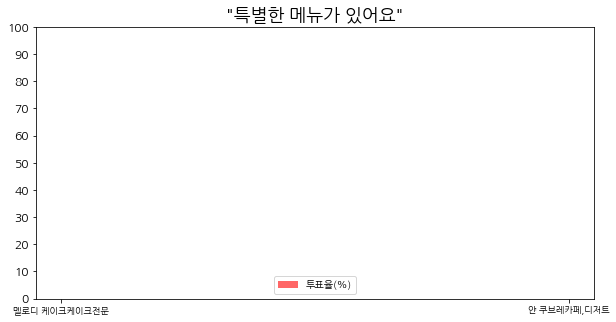

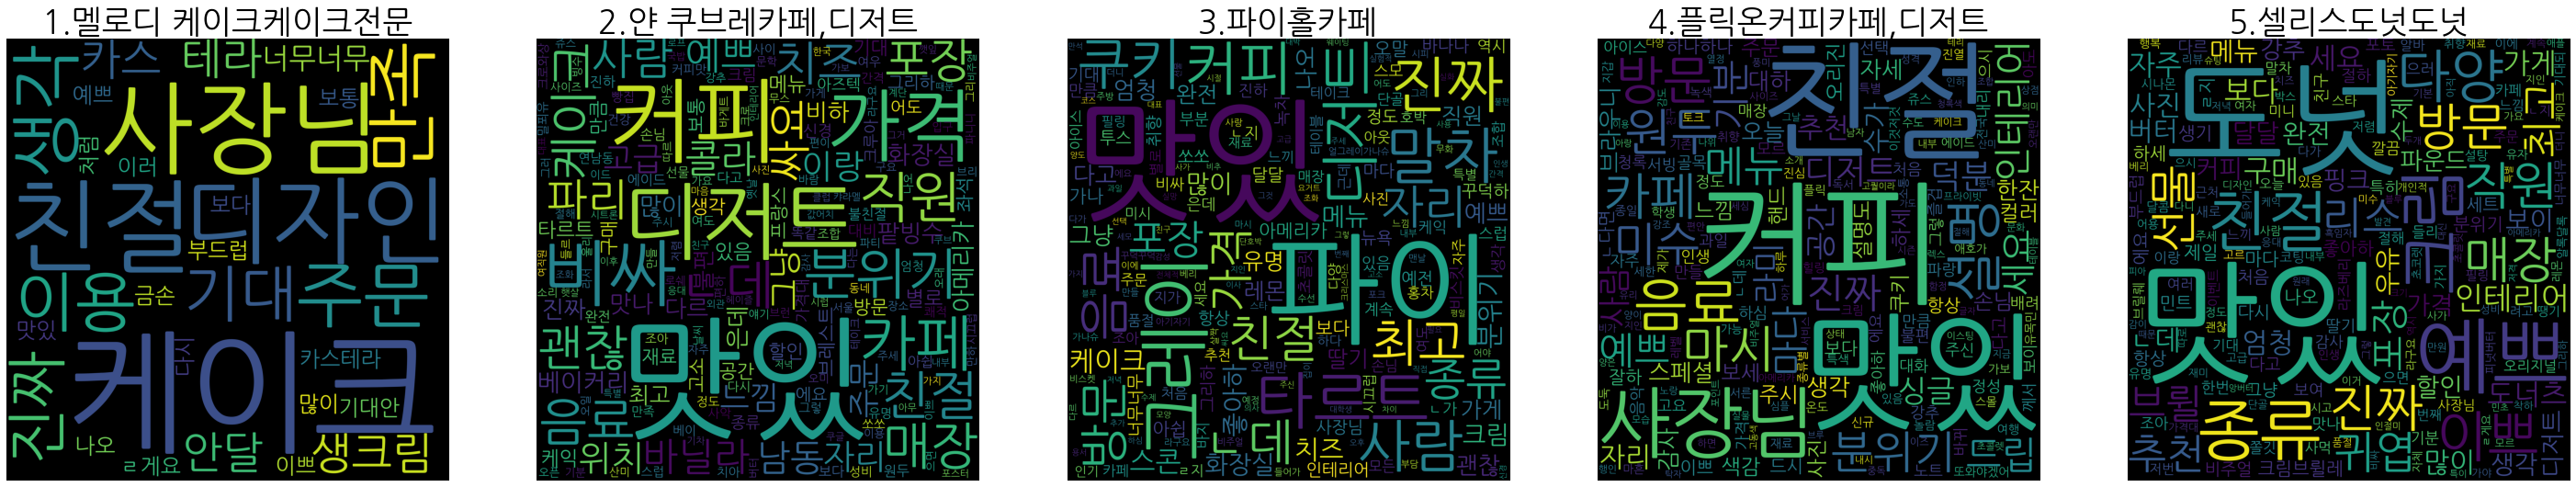

In [ ]:
%run Group3WebCrawling.py